# Anime Recommendation: Collaborative Filtering Approach

## Overview
This project aims to build an anime recommendation system for new members and current subscribers of an anime streaming service. New members can use a content-based approach to receive recommendations based on a show they may have watched or heard of previosuly. For current subscribers, collaborative filtering is used by comparing the users' ratings and returning shows similar users have rated similarly. 


## Business Understanding
The anime industry is a rapidly growing market, with new shows being released all the time. This can make it difficult for anime fans to find new shows to watch that they will enjoy. Additionally, most streaming services do not offer personalized recommendations, which can lead to users wasting time scrolling through an endless list of shows that they are not interested in.
With this project, I aim to build a recommendation system that will help anime fans discover new shows that they will enjoy. The recommendation system will use a variety of factors to make recommendations, including the user's past viewing history, the user's ratings of other shows, and the user's genre preferences. 
This recommendation system  will give a curated list to its users based on content preference and similar user's pick that will save time and provide a superb experience both novel and familiar to users. 

## Collaborative Filtering

In [1]:
import pandas as pd
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reviews = pd.read_csv('Data/cleaned_reviews.csv')
reviews

,Unnamed: 0,user_id,anime_id,rating
0,47,1,8074,10
1,81,1,11617,10
2,83,1,11757,10
3,101,1,15451,10
4,153,2,11771,10
...,...,...,...,...
6337236,7813732,73515,16512,7
6337237,7813733,73515,17187,9
6337238,7813734,73515,22145,10
6337239,7813735,73516,790,9


In [3]:
reviews.shape

(6337241, 4)

In [4]:
reviews.groupby('user_id').count().sort_values(by='rating')

,Unnamed: 0,anime_id,rating
user_id,,,
34856,1,1,1
52656,1,1,1
52654,1,1,1
3859,1,1,1
52641,1,1,1
...,...,...,...
51693,2621,2621,2621
59643,2632,2632,2632
57620,2689,2689,2689


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6337241 entries, 0 to 6337240
Data columns (total 4 columns):
 #   Column      Dtype
---  ------      -----
 0   Unnamed: 0  int64
 1   user_id     int64
 2   anime_id    int64
 3   rating      int64
dtypes: int64(4)
memory usage: 193.4 MB


In [6]:
reviews.isna().sum()

Unnamed: 0    0
user_id       0
anime_id      0
rating        0
dtype: int64

In [7]:
reader = Reader(rating_scale=(1, 10))

users = Dataset.load_from_df(reviews[['user_id', 'anime_id', 'rating']], reader)

trainset, testset = train_test_split(users, test_size=0.25, random_state=42)

### Baseline Models

In [8]:
baseline_normal = NormalPredictor()
baseline_normal.fit(trainset)

predictions = baseline_normal.test(testset)

normal_acc = accuracy.rmse(predictions)

RMSE: 2.1476


In [9]:
# instantiating model
baseline_only = BaselineOnly()
baseline_only.fit(trainset)

# saving test predictions
predictions = baseline_only.test(testset)

base_acc = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.2070


### Single Value Decomposition

In [10]:
svd_base = SVD(random_state=42)

results = cross_validate(svd_base, users, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1338  1.1336  1.1347  1.1317  1.1352  1.1338  0.0012  
Fit time          270.97  261.93  266.40  263.06  263.96  265.27  3.21    
Test time         12.47   11.89   12.14   11.84   10.64   11.80   0.62    


In [11]:
# fitting trainset
svd_base.fit(trainset)

# saving test predictions
predictions = svd_base.test(testset)

svd_base_acc = accuracy.rmse(predictions)

RMSE: 1.1397


The simple SVD is slightly better than the baseline model with a RMSE reduction of approximately 0.067 and from the normal predictor of approximately 1.008. I will use grid searches to determine the best hyperparameters for the model.

### SVD and Grid Searches

In [12]:
params_1 = {'n_factors':[5, 10], 'n_epochs': [10, 20], 'biased': [True, False]}

svd_grid_1 = GridSearchCV(SVD,param_grid=params_1,joblib_verbose=10, n_jobs=-1, cv=3)

svd_grid_1.fit(users)

svd_grid_1.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:  4.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:  5.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:  6.8min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:  7.3min remaining:   35.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.5min finished


{'n_factors': 10, 'n_epochs': 20, 'biased': True}

In [13]:
# instantiating model with best params from search
svd_1 = SVD(n_factors=10, n_epochs=20, random_state=42)

# fitting to train set
svd_1.fit(trainset)

# getting test predictions
predictions = svd_1.test(testset)

# calculating and saving rmse
svd_1_acc = accuracy.rmse(predictions)

RMSE: 1.1382


This model is doing only slightly better than the simple SVD with the best hyperparameters found in the fist grid search. I will add more paramerters in the dictionary next.

In [14]:
# new gridsearch 
params_2 = {'n_factors':[10, 20], 'n_epochs': [20, 40],'lr_all': [0.05, .005], 
            'reg_all': [0.01, 0.02]}

svd_grid_2 = GridSearchCV(SVD,param_grid=params_2,joblib_verbose=10, n_jobs=-1, cv=3)


svd_grid_2.fit(users)
svd_grid_2.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed: 22.7min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed: 27.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 27.6min finished


{'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

In [15]:
# new model with best params from second gridsearch
svd_2 = SVD(n_factors=20, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)

# fitting to train set
svd_2.fit(trainset)

# getting test predictions
predictions = svd_2.test(testset)

# calculating and saving rmse
svd_2_acc = accuracy.rmse(predictions)

RMSE: 1.1365


This search shows some slight improvement compared to the previous one and the baseline models. I will continue grid searching with different parameters to determine if I can improve the RMSE further.

In [16]:
# new gridsearch 
params_3 = {'n_factors':[20,30],'n_epochs': [20,25],'lr_all': [0.05, .005, 0.001],
            'reg_all': [0.02, 0.03]}

svd_grid_3 = GridSearchCV(SVD,param_grid=params_3,joblib_verbose=10, n_jobs=-1, cv=3)


svd_grid_3.fit(users)
svd_grid_3.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 110 out of 120 | elapsed: 35.9min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 38.1min finished


{'n_factors': 30, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.03}

In [17]:
# new model with best params from second gridsearch
svd_3 = SVD(n_factors=30, n_epochs=25, lr_all=0.005, reg_all=0.03, random_state=42)

# fitting to train set
svd_3.fit(trainset)

# getting test predictions
predictions = svd_3.test(testset)

# calculating and saving rmse
svd_3_acc = accuracy.rmse(predictions)

RMSE: 1.1293


The RMSE seems to be improving slightly. To be certain, I will run one more search to determine the best model.

In [18]:
params_4 = {'n_factors':[30,40],'n_epochs': [25,30],'lr_all': [0.005, .001],
            'reg_all': [0.03, 0.05]}

svd_grid_4 = GridSearchCV(SVD,param_grid=params_4,joblib_verbose=10, n_jobs=-1, cv=3)


svd_grid_4.fit(users)
svd_grid_4.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed: 30.2min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed: 34.6min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 35.2min finished


{'n_factors': 40, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}

In [19]:
# new model with best params from second gridsearch
svd_4 = SVD(n_factors=40, n_epochs=30, lr_all=0.005, reg_all=0.05, random_state=42)

# fitting to train set
svd_4.fit(trainset)

# getting test predictions
predictions = svd_4.test(testset)

# calculating and saving rmse
svd_4_acc = accuracy.rmse(predictions)

RMSE: 1.1209


The RMSE is only slightly smaller than before. I decided to stop the search here and compare SVD 2 to NMF and SVDPP before testing the model.

### Non-Negative Matrix Factorization (NMF) Grid Seach 

In [10]:
# setting up serach for nmf
nmf_params_1 = {'n_factors':[5, 10],
             'n_epochs':[20, 30],
             'biased': [True, False]}

nmf_grid_1 = GridSearchCV(NMF, param_grid=nmf_params_1, cv=3, joblib_verbose=10, n_jobs=-1)


nmf_grid_1.fit(users)
nmf_grid_1.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   4 out of  24 | elapsed:  2.4min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done   7 out of  24 | elapsed:  3.5min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:  4.0min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:  4.7min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:  5.0min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:  6.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  6.9min remaining:   37.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.0min finished


{'n_factors': 5, 'n_epochs': 30, 'biased': True}

In [11]:
nmf_1 = NMF(n_factors=5, n_epochs=30, random_state=42, biased=True)
nmf_1.fit(trainset)
predictions = nmf_1.test(testset)
nmf_1_acc = accuracy.rmse(predictions)

RMSE: 1.2067


This model perfoms worse than all the SVD models with a slighly higher RMSE.

### SVDPP & Grid Search

In [12]:
svdpp_params = {'n_factors':[1, 5],
                    'n_epochs':[25, 50],
                    'reg_all':[0.02, 0.05]}
svdpp_grid_1 = GridSearchCV(SVDpp, param_grid=svdpp_params, cv=3, joblib_verbose=10, n_jobs=-1)

svdpp_grid_1.fit(users)
svdpp_grid_1.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [345]:
svdpp_1 = SVDpp(n_factors=5, n_epochs=50, reg_all=0.02, random_state=42,)
svdpp_1.fit(trainset)
predictions = svdpp_1.test(testset)
svdpp_1_acc = accuracy.rmse(predictions)

RMSE: 1.6096


### Model Comparison
After many iterations of SVD models, model 2 achived the lowest RMSE of 1.531 and will be used as the final model for recommendations. I compared this RMSE to the results from the Normal and Baseline Only predictions used as baselines that had RMSEs of 3.095 and 1.962, respectively. 

In [20]:
X = ['Baseline', 'SVD Basic', 'SVD 2', 'NMF', 'SVDpp']
y = [normal_acc, svd_base_acc, svd_2_acc, nmf_1_acc, svdpp_1_acc]

NameError: name 'nmf_1_acc' is not defined

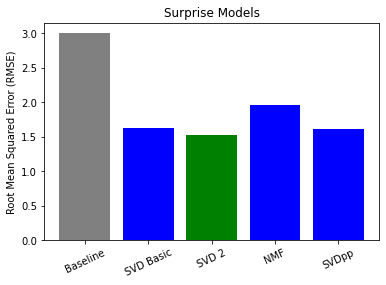

In [347]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['grey', 'blue', 'green', 'blue', 'blue'])
plt.xticks(rotation=25)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('Images/model_comparison.png', dpi=400);

## Building Recommendation Model
The following code was sourced from one of my instructor's projects, linked [here](https://github.com/danielburdeno/Kindle-eBook-Recommendations/blob/main/CollaborativeFiltering.ipynb), and adjusted for this model.

In [365]:
trainset = users.build_full_trainset()
svd_2.fit(trainset)

In [367]:
df_original = pd.read_csv('Data/anime_cleaned.csv', index_col='uid')
df_original.drop(columns =['Unnamed: 0'], inplace=True)
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13854 entries, 28891 to 16934
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       13854 non-null  object 
 1   synopsis    13854 non-null  object 
 2   genre       13854 non-null  object 
 3   aired       13854 non-null  object 
 4   episodes    13854 non-null  float64
 5   members     13854 non-null  int64  
 6   popularity  13854 non-null  int64  
 7   ranked      13854 non-null  float64
 8   score       13854 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.1+ MB


In [368]:
df_original.head()

,title,synopsis,genre,aired,episodes,members,popularity,ranked,score
uid,,,,,,,,,
28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82
23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83
34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83
5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23
31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83


In [393]:
df_original.iloc[1281]

title                   Thermae Romae: Kodai Romajin ga Uchuu e
synopsis      Lucius ends up in a space station, where he ex...
genre                             ['Space', 'Comedy', 'Seinen']
aired                                              Apr 20, 2012
episodes                                                      1
members                                                    1057
popularity                                                 9401
ranked                                                     8055
score                                                      6.09
Name: 13983, dtype: object

In [369]:
user_ids = reviews.set_index('uid')
user_ids.drop(columns=['score'], inplace=True)
user_ids.head()

,anime_uid
uid,
255938,34096
259117,34599
253664,28891
8254,2904
291149,4181


In [394]:
user_ids.dtypes

anime_uid    object
dtype: object

In [395]:
user_ids['anime_uid'] = user_ids['anime_uid'].astype(int)

In [370]:
user_ids.to_csv('Data/user_anime_df.csv')

In [413]:
user = input('UserID: ')
recs = int(input('Number of Recommendations: '))

UserID: 321144
Number of Recommendations: 5


In [414]:
reviewed = list(user_ids.loc[user, 'anime_uid'])
reviewed

[40269, 40269, 40269, 40269]

In [415]:
# original dataset copy to subset on reviewed shows
not_reviewed = df_original.copy()
not_reviewed.drop(reviewed, inplace=True)
not_reviewed.reset_index(inplace=True)
not_reviewed.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83


In [416]:
not_reviewed['est_rating'] = not_reviewed['uid'].apply(lambda x: svd_2.predict(user, x).est)

not_reviewed.sort_values(by='est_rating',  ascending=False, inplace=True)
not_reviewed.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,est_rating
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,6.997509
9239,24489,Koha Ginjiro,"After the death of his elder brother, Ginjiro ...","['Action', 'Drama', 'School', 'Shounen']","May 22, 1991 to Nov 20, 1991",3.0,211,13237,12757.0,5.93,6.997509
9228,39028,Komatsu Sakyo Anime Gekijou: Tokubetsu-hen,Unaired episodes of Komatsu Sakyo Anime Gekij...,"['Comedy', 'Parody', 'Sci-Fi', 'Space']","Mar 23, 1990 to Jun 22, 1990",3.0,64,16007,12770.0,5.88,6.997509
9229,26109,Kokoro no Koukyougaku,An educational film about child abuse in Japan.,"['Drama', 'Kids']",2002,1.0,113,15049,12766.0,6.83,6.997509
9230,26293,Kokoro no Hanataba,A sweet story about an old man who went around...,['Kids'],2001,1.0,104,15241,12765.0,7.58,6.997509


In [417]:
not_reviewed['est_rating'].value_counts()

6.997509    13852
Name: est_rating, dtype: int64

In [387]:
def anime_rec():
    
    user = input('UserID: ')
    recs = int(input('Number of Recommendations: '))
    
    reviewed = list(user_ids.loc[user, 'anime_uid'])
    
    not_reviewed = df_original.copy()
    not_reviewed.reset_index(inplace=True)
    not_reviewed['est_rating'] = not_reviewed['uid'].apply(lambda x: svd_2.predict(user, x).est)
    not_reviewed.sort_values(by='est_rating',  ascending=False, inplace=True)
    
    return not_reviewed.head(recs)

In [388]:
anime_rec()

UserID: 299323
Number of Recommendations: 5


,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,est_rating
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,7.834754
9240,26345,Kogitsune no Okurimono,Three child kitsune break a precious family po...,"['Drama', 'Fantasy', 'Kids']",1993,1.0,110,15111,12755.0,6.80,7.834754
9229,39916,Kome no Uta,Music video for the song Kome no Uta by Japa...,"['Kids', 'Music']","Feb 1, 1998",1.0,35,16285,12771.0,5.00,7.834754
9230,39028,Komatsu Sakyo Anime Gekijou: Tokubetsu-hen,Unaired episodes of Komatsu Sakyo Anime Gekij...,"['Comedy', 'Parody', 'Sci-Fi', 'Space']","Mar 23, 1990 to Jun 22, 1990",3.0,64,16007,12770.0,5.88,7.834754
9231,26109,Kokoro no Koukyougaku,An educational film about child abuse in Japan.,"['Drama', 'Kids']",2002,1.0,113,15049,12766.0,6.83,7.834754


## Conclusions 
In conclusion, the collaborative filtering recommendation system is able to predict estimated ratings with an error of 1.5 and return recommendations that a user will most likely rate highly based on their previous rating patterns and similar users' ratings of the recommendations.
Overall, collaborative filtering is a powerful technique that can be used to recommend anime to users. However, it is important to be aware of the limitations of the approach and to use it in conjunction with other techniques, such as content-based filtering, to provide the best possible recommendations.
Some of the limitations of collaborative filtering:
 - Data sparsity: Collaborative filtering algorithms rely on users having rated a large number of items. However, in practice, many users only rate a small number of items. This can lead to inaccurate recommendations.
    -  One way to overcome data sparsity is to use content-based filtering in conjunction with collaborative filtering. Content-based filtering algorithms recommend items to users based on the content of the items that the user has rated. This can help to fill in the gaps in the data that is available for collaborative filtering.
 - Cold start: Collaborative filtering algorithms cannot recommend items to users who have not yet rated any items. This can be a problem for new users or users who have recently changed their interests.
    -  A potential solution to the cold start problem is to use a hybrid approach that combines collaborative filtering with content-based filtering. In this approach, the algorithm first uses content-based filtering to recommend items to the new user. The algorithm then uses collaborative filtering to refine the recommendations by taking into account the ratings of other users.
 - Bias: Collaborative filtering algorithms can be biased by the ratings of other users. For example, if a user only rates popular items, the algorithm will recommend other popular items to that user, even if the user might prefer less popular items.
    - One way to overcome bias is to use a variety of collaborative filtering algorithms and to combine their results. This can help to reduce the impact of any individual algorithm's biases.